# Exploratory Analysis of Domestic Flights Arriving at LaGuardia

Data source:

Bureau of Transportation Statistics, United States Department of Transportation

https://www.transtats.bts.gov/DL_SelectFields.asp?Table_ID=236

# Read the data into a single dataframe

Manually downloaded airline [On-Time Performance data set](https://www.transtats.bts.gov/DL_SelectFields.asp?Table_ID=236) for every month from January 2016 through 2017 YTD as zip files to `data/flights/`.

Concatenate all of these files into a single data frame.

In [2]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime as dt
%matplotlib inline

In [3]:
def read_flight_data(path_to_data):
    list_of_dataframes = []
    
    for filename in os.listdir(path_to_data):
        df = pd.read_csv(os.path.join(path_to_data, filename), compression='infer')
        list_of_dataframes.append(df)
    
    output = pd.concat(list_of_dataframes)
    
    # Drop any columns with "Unnamed" in the header
    drop_columns = [i for i in output.columns if 'Unnamed' in i]
    output = output.drop(drop_columns, axis=1)
    
    # Filter the data to only include flights arriving at LGA
    output = output[output['DEST'] == 'LGA']
    
    # Sort output by date and scheduled departure time
    output['FL_DATE'] = pd.to_datetime(output['FL_DATE'])
    output = output.sort_values(by=['FL_DATE', 'CRS_DEP_TIME'])
    output = output.reset_index(drop=True)
    
    return output     

In [4]:
df = read_flight_data("../raw_data/flights")

In [5]:
df.head()

YEAR QUARTER MONTH DAY_OF_MONTH DAY_OF_WEEK    FL_DATE UNIQUE_CARRIER  \
0  2016       1     1            1           5 2016-01-01             NK   
1  2016       1     1            1           5 2016-01-01             NK   
2  2016       1     1            1           5 2016-01-01             B6   
3  2016       1     1            1           5 2016-01-01             B6   
4  2016       1     1            1           5 2016-01-01             AA   

  AIRLINE_ID CARRIER TAIL_NUM    ...    DEST_WAC CRS_DEP_TIME DEP_TIME  \
0      20416      NK   N641NK    ...          22          546      NaN   
1      20416      NK   N636NK    ...          22          600    624.0   
2      20409      B6   N623JB    ...          22          600    556.0   
3      20409      B6   N599JB    ...          22          600    553.0   
4      19805      AA   N3KRAA    ...          22          605    714.0   

  DEP_DELAY DEP_DELAY_NEW WHEELS_ON TAXI_IN CRS_ARR_TIME ARR_TIME ARR_DELAY  
0       NaN           NaN       NaN     NaN          850      NaN       NaN  
1      24.0          24.0     740.0     8.0          735    748.0      13.0  
2      -4.0           0.0     806.0     5.0          825    811.0     -14.0  
3      -7.0           0.0     819.0     5.0          841    824.0     -17.0  
4      69.0          69.0     947.0     5.0          857    952.0      55.0  

[5 rows x 34 columns]

# Exploratory Data Analysis

### How many flights arrive at LaGuardia per day?

In [6]:
def count_flights_per_day(df):
    flights_per_day = pd.DataFrame(columns = ['FL_DATE','NUM_FLIGHTS'])
    flights_per_day['FL_DATE'] = df['FL_DATE'].value_counts().index
    flights_per_day['NUM_FLIGHTS'] = df['FL_DATE'].value_counts().values
    flights_per_day = flights_per_day.sort_values(by='FL_DATE')
    flights_per_day = flights_per_day.reset_index(drop=True)
    
    # Plot number of arrivals at LGA per day
    ax = flights_per_day.plot(kind='bar', figsize=(60,20), title='Number of LGA Arrivals per Day Since Jan 2016')
    ax.set_xticklabels(flights_per_day['FL_DATE'].dt.date) # removes timestamp from datetime
    ax.set_ylabel("Number of Arrivals")
    
    return flights_per_day

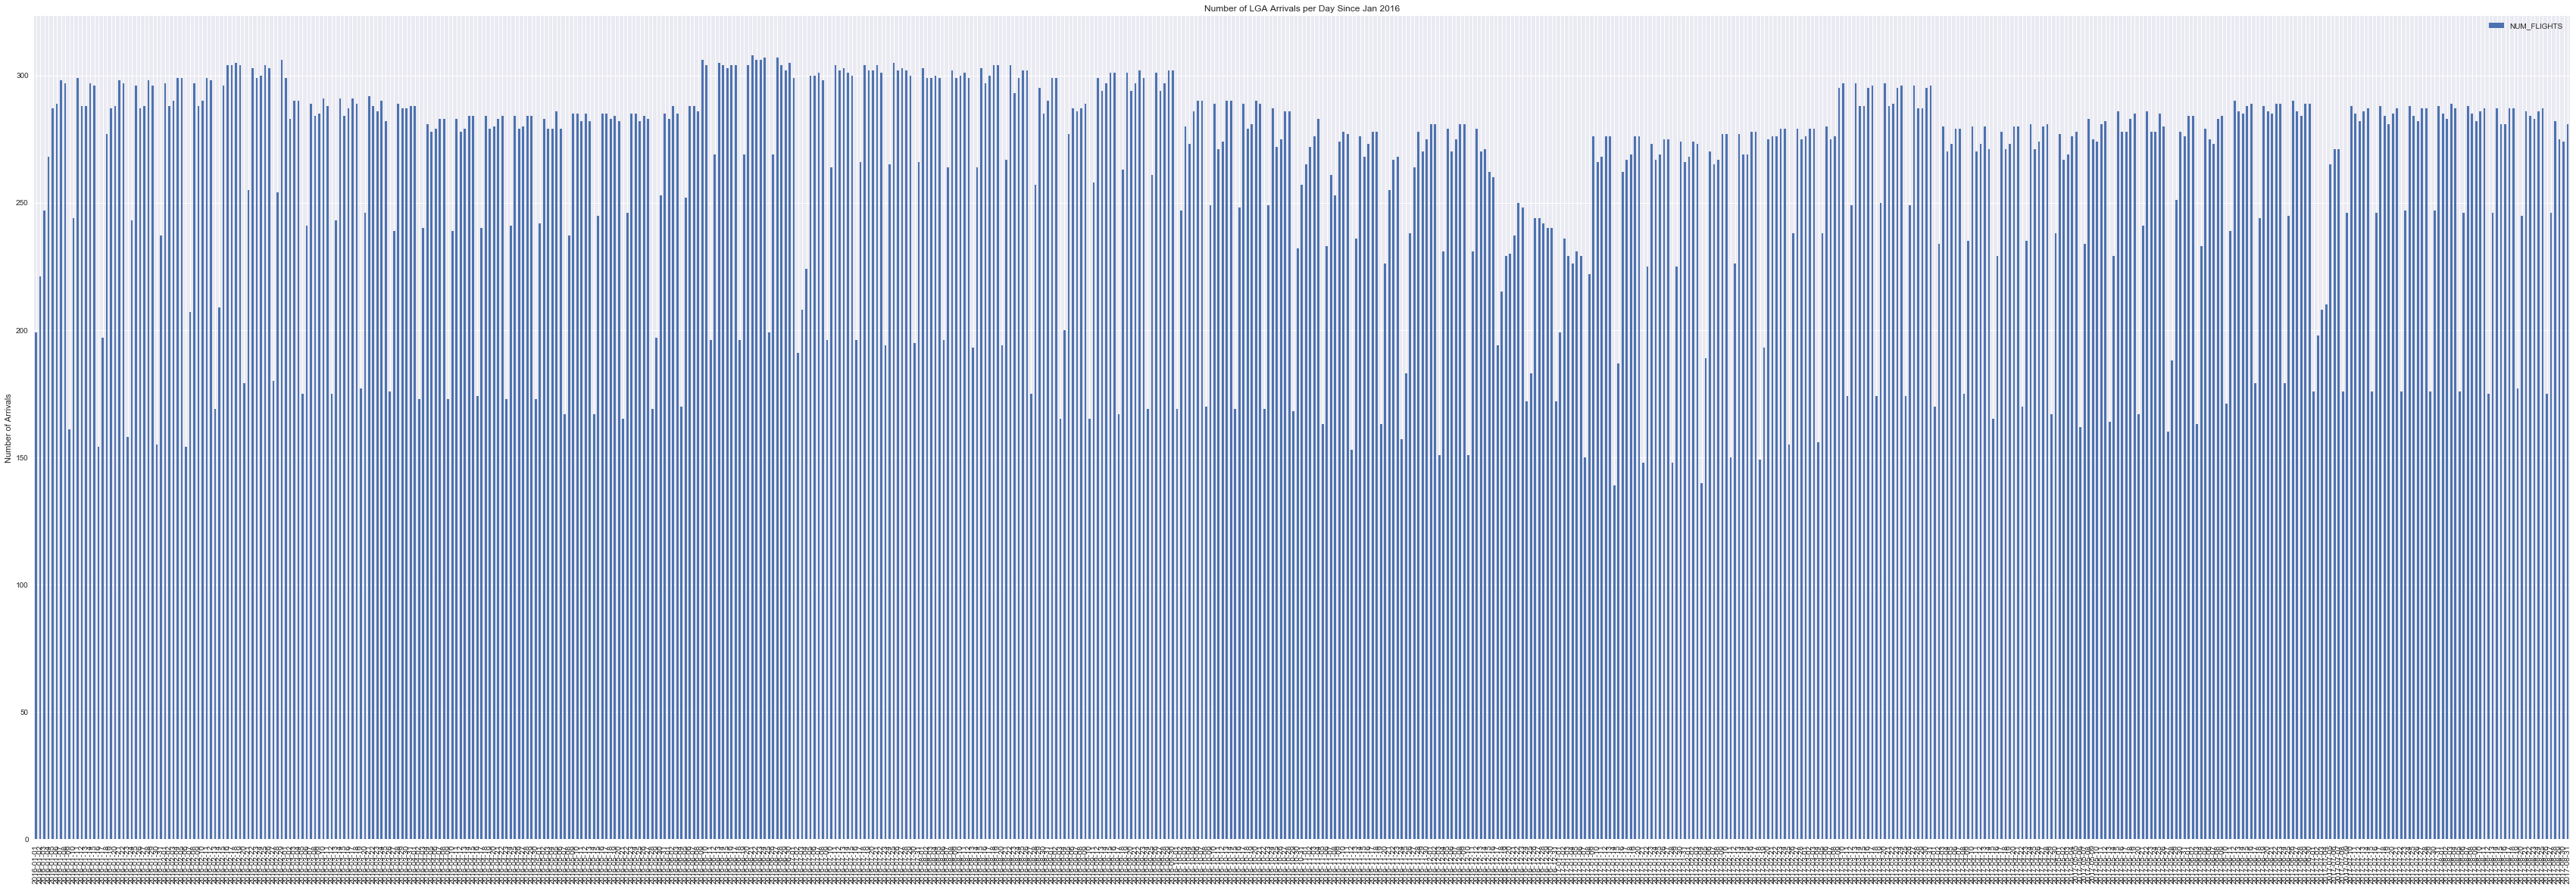

In [7]:
flights_per_day = count_flights_per_day(df)

In [8]:
flights_per_day.head()

FL_DATE  NUM_FLIGHTS
0 2016-01-01          199
1 2016-01-02          221
2 2016-01-03          247
3 2016-01-04          268
4 2016-01-05          287

### How many flights arrive at LaGuardia per month?

In [9]:
def count_flights_per_month(flights_per_day):
    flights_per_day.index = flights_per_day['FL_DATE'] # Set index to date so we can use TimeGrouper
    flights_per_month = pd.DataFrame(flights_per_day.groupby(pd.TimeGrouper(freq='M')).sum())
    
    # Plot number of arrivals at LGA per month
    ax = flights_per_month.plot(kind='bar', title='Number of LGA Arrivals per Month Since Jan 2016', legend=False, 
                                figsize=(16,8), fontsize=14)
    ax.set_xticklabels(pd.Series(flights_per_month.index).apply(dt.date).apply(lambda x: str(x)[:7])) # removes day and timestamp from datetime
    ax.set_ylabel("Number of Arrivals")
    ax.set_xlabel("Month")
    
    return flights_per_month

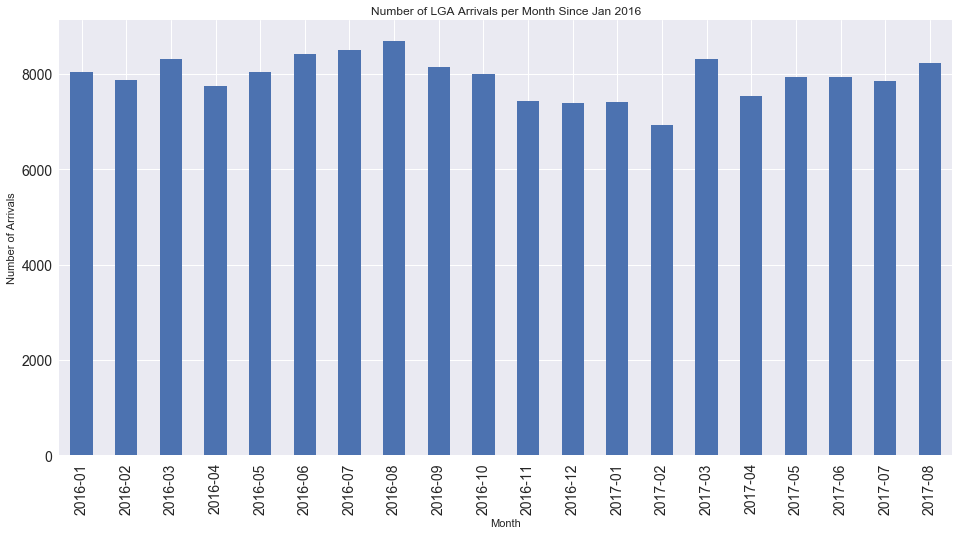

In [10]:
flights_per_month = count_flights_per_month(flights_per_day)

In [11]:
flights_per_month.head()

NUM_FLIGHTS
FL_DATE                
2016-01-31         8035
2016-02-29         7880
2016-03-31         8302
2016-04-30         7747
2016-05-31         8036

### What is the average number of flights arriving per hour?

Actual arrival time (`ARR_TIME`) comes in a weird format: "hhmm" (local time)

Here's a function to convert "hhmm" format to a datetime time object.

In [12]:
def convert_hhmm_to_time(hhmm):
    hhmm = str(int(hhmm))
    
    if hhmm == '2400': # hour must be btw 0 and 23
        hhmm = '2359'  
    
    if len(hhmm) > 2:  # to handle conversions like '1025' => 10:25:00
        hour = hhmm[:-2]
        minute = hhmm[-2:]
        second = "00"
        time_string = hour + ":" + minute + ":" + second
        date_time = pd.to_datetime(time_string)
        time = dt.time(date_time) 
        
    if len(hhmm) <= 2: # to handle conversions like '2' => 00:02:00
        hour = "00"
        minute = hhmm.zfill(2)
        second = "00"
        time_string = hour + ":" + minute + ":" + second
        date_time = pd.to_datetime(time_string)
        time = dt.time(date_time)
        
    return str(time)

Test it out to make sure it works:

In [13]:
convert_hhmm_to_time(1025.0)

'10:25:00'

In [14]:
def calculate_avg_flights_per_hour(df):
    time_stamps = pd.Series(df['ARR_TIME'].dropna())
    time_stamps = time_stamps.apply(convert_hhmm_to_time)
    hours = time_stamps.apply(lambda x: x.split(':')[0])
    hours = pd.DataFrame(hours)
    hours.columns = ['ARR_HOUR']
    count_per_hour = hours['ARR_HOUR'].value_counts().sort_index()
    number_of_days = (df['FL_DATE'].max() - df['FL_DATE'].min()).days
    average_per_hour = count_per_hour / number_of_days
    
    # Plot average number of arrivals at LGA per hour per day
    ax = average_per_hour.plot(kind='bar', title='Average Number of Arriving Flights per Hour per Day at LaGuardia', figsize=(16,8))
    ax.set_ylabel("Average Number of Arrivals")
    ax.set_xlabel("Hour")
    
    return average_per_hour

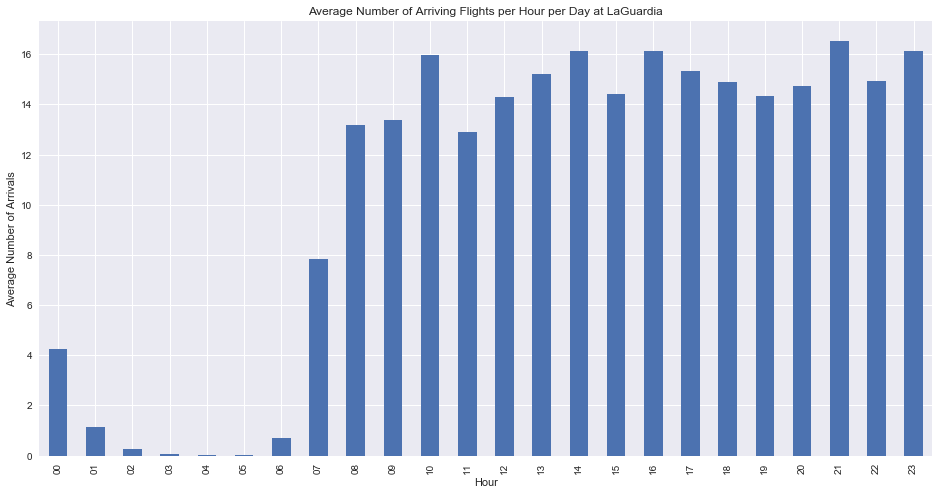

In [15]:
avg_flights_per_hour = calculate_avg_flights_per_hour(df)

In [16]:
avg_flights_per_hour

00     4.241776
01     1.128289
02     0.253289
03     0.054276
04     0.026316
05     0.027961
06     0.680921
07     7.851974
08    13.159539
09    13.363487
10    15.967105
11    12.911184
12    14.300987
13    15.213816
14    16.146382
15    14.424342
16    16.129934
17    15.337171
18    14.889803
19    14.350329
20    14.730263
21    16.511513
22    14.924342
23    16.123355
Name: ARR_HOUR, dtype: float64

### What is the average number of flights arriving by day of week?

In [17]:
days_of_week = {
    "1":"Monday",
    "2":"Tuesday",
    "3":"Wednesday",
    "4":"Thursday",
    "5":"Friday",
    "6":"Saturday",
    "7":"Sunday",
    "9":"Unknown"
}

In [18]:
def calculate_avg_flights_per_day_of_week(df, days_of_week):
    counts_by_day_of_week = df['DAY_OF_WEEK'].value_counts().sort_index()
    number_of_days = (df['FL_DATE'].max() - df['FL_DATE'].min()).days
    average_per_day_of_week = counts_by_day_of_week / number_of_days

    # Plot average number of arrivals at LGA per hour per day
    ax = average_per_day_of_week.plot(kind='bar', title='Average Number of Arriving Flights at LaGuardia by Day of Week', figsize=(16,8))
    ax.set_ylabel("Average Number of Arrivals")
    ax.set_xlabel("Day of Week")
    xticklabels = [days_of_week[str(i)] for i in list(average_per_day_of_week.index)]
    ax.set_xticklabels(xticklabels)

    return average_per_day_of_week

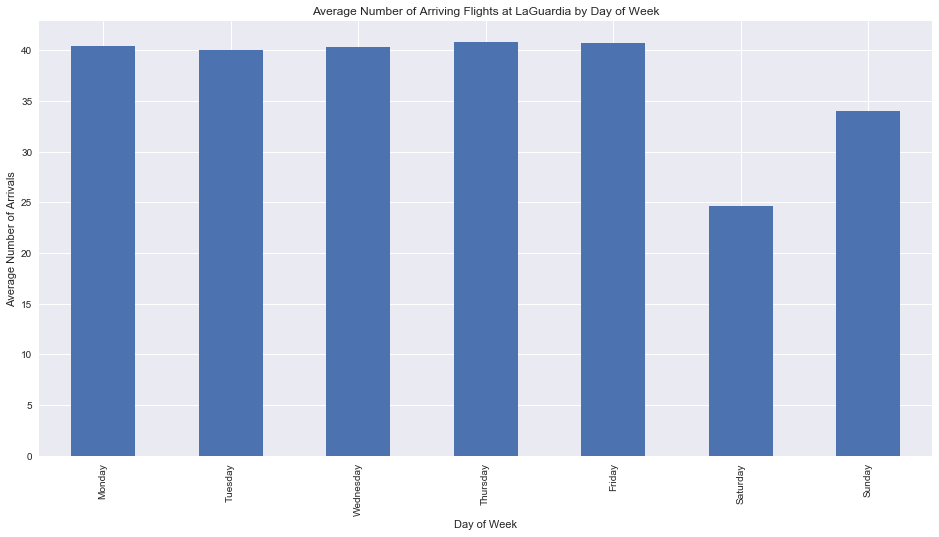

In [19]:
avg_flights_per_day = calculate_avg_flights_per_day_of_week(df, days_of_week)

### Count number of flights for every hour since 2016

In [41]:
def count_flights_per_hour(df):
    data = df.copy()
    data = data.dropna(subset=['ARR_TIME'])
    data = data.reset_index(drop=True)
    time_stamps = pd.Series(data['ARR_TIME'])
    time_stamps = time_stamps.apply(convert_hhmm_to_time)
    data['TIME_STAMP'] = time_stamps
    dates = pd.Series(data['FL_DATE'].apply(lambda x: str(x).split(" ")[0]))
    data['DATE_STRING'] = dates
    data['FL_DATETIME'] = pd.to_datetime(data['DATE_STRING'] + " " + data['TIME_STAMP'])
    
    # Make dataframe of number of flights per hour since 2016
    output = data['FL_DATETIME']
    output.index = data['FL_DATETIME']
    output = pd.DataFrame(output.groupby(pd.TimeGrouper(freq='H')).count().sort_index())
    output.columns = ['NUM_FLIGHTS']
    
    return output

In [42]:
flights_per_hour = count_flights_per_hour(df)

# Save flights per hour to CSV

This is the clean hourly flight data that will go into our model.

In [43]:
flights_per_hour

NUM_FLIGHTS
FL_DATETIME                     
2016-01-01 00:00:00            1
2016-01-01 01:00:00            1
2016-01-01 02:00:00            0
2016-01-01 03:00:00            0
2016-01-01 04:00:00            0
2016-01-01 05:00:00            0
2016-01-01 06:00:00            0
2016-01-01 07:00:00            2
2016-01-01 08:00:00            5
2016-01-01 09:00:00            8
2016-01-01 10:00:00            6
2016-01-01 11:00:00            9
2016-01-01 12:00:00           11
2016-01-01 13:00:00           12
2016-01-01 14:00:00           18
2016-01-01 15:00:00           11
2016-01-01 16:00:00           16
2016-01-01 17:00:00           19
2016-01-01 18:00:00           15
2016-01-01 19:00:00           12
2016-01-01 20:00:00           17
2016-01-01 21:00:00           13
2016-01-01 22:00:00           12
2016-01-01 23:00:00           10
2016-01-02 00:00:00            0
2016-01-02 01:00:00            1
2016-01-02 02:00:00            0
2016-01-02 03:00:00            0
2016-01-02 04:00:00            0
2016-01-02 05:00:00            0
...                          ...
2017-08-30 18:00:00           18
2017-08-30 19:00:00           15
2017-08-30 20:00:00           18
2017-08-30 21:00:00           19
2017-08-30 22:00:00            8
2017-08-30 23:00:00           12
2017-08-31 00:00:00            0
2017-08-31 01:00:00            0
2017-08-31 02:00:00            0
2017-08-31 03:00:00            0
2017-08-31 04:00:00            0
2017-08-31 05:00:00            0
2017-08-31 06:00:00            1
2017-08-31 07:00:00           11
2017-08-31 08:00:00           14
2017-08-31 09:00:00           22
2017-08-31 10:00:00           14
2017-08-31 11:00:00           14
2017-08-31 12:00:00           14
2017-08-31 13:00:00           17
2017-08-31 14:00:00           17
2017-08-31 15:00:00           16
2017-08-31 16:00:00           16
2017-08-31 17:00:00           23
2017-08-31 18:00:00           16
2017-08-31 19:00:00           13
2017-08-31 20:00:00           17
2017-08-31 21:00:00           18
2017-08-31 22:00:00           11
2017-08-31 23:00:00           16

[14616 rows x 1 columns]

In [45]:
flights_per_hour.to_csv("../clean_data/flights_per_hour.csv")

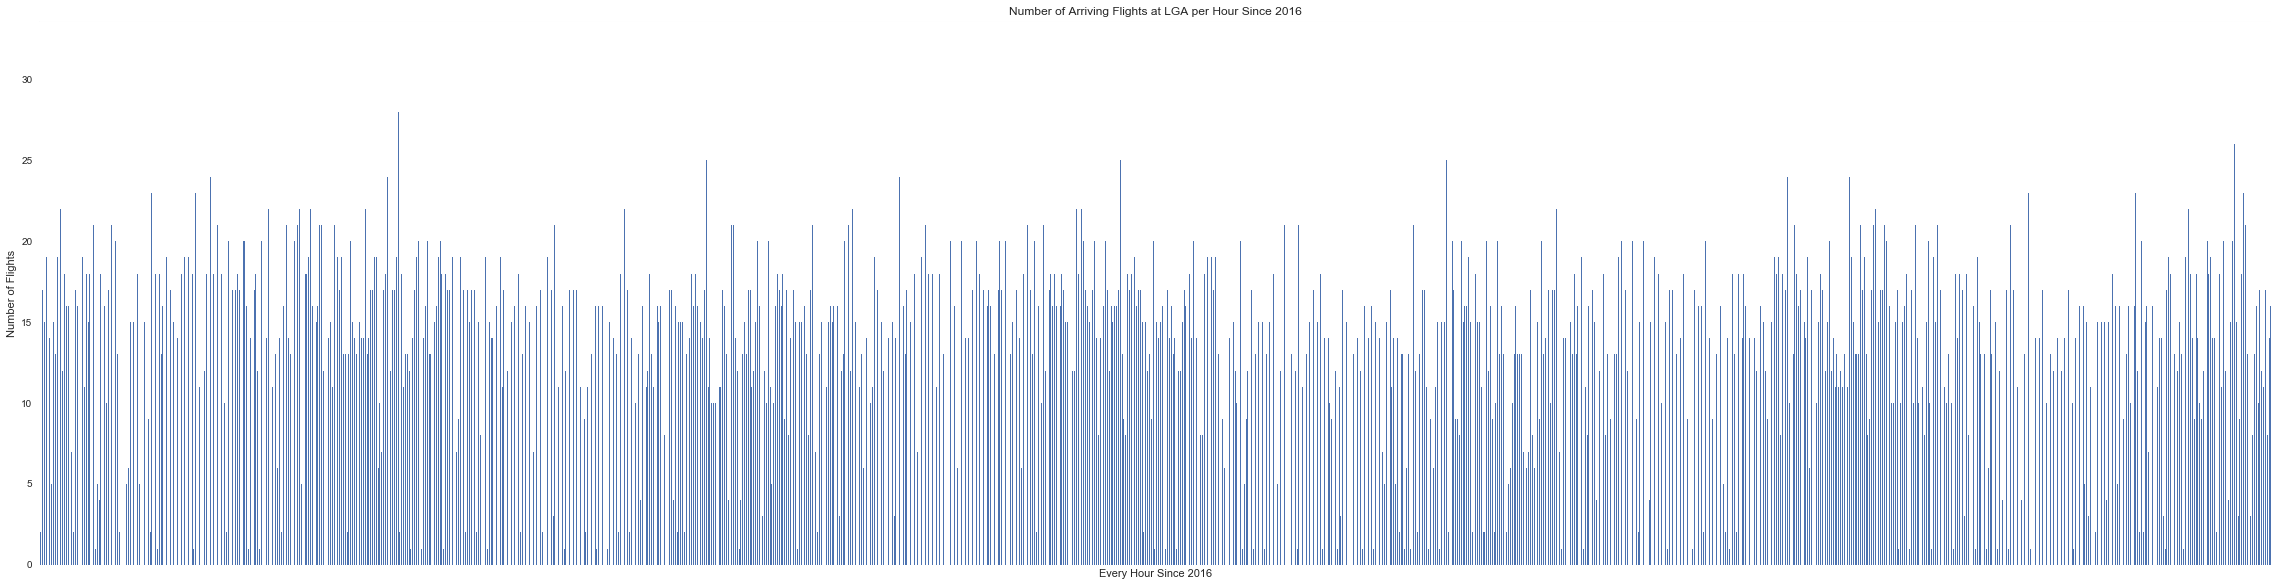

In [47]:
ax = flights_per_hour.plot(kind='bar', figsize=(40,10), title='Number of Arriving Flights at LGA per Hour Since 2016', legend=False)
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='off')
ax.set_xlabel("Every Hour Since 2016")
ax.set_ylabel("Number of Flights")

# Everything below here is a work in progres...

# Mapping Tail Numbers to Aircraft Models

http://registry.faa.gov/aircraftinquiry/NNum_Results.aspx?NNumbertxt=N14249 seems promising.

Make a list of unique tail numbers of flights arriving at LGA.

In [244]:
tail_nums = np.array(df['TAIL_NUM'])
tail_nums = tail_nums[~pd.isnull(tail_nums)] # remove nan's
unique_tail_nums = np.unique(tail_nums) # get unique tail nums
print len(unique_tail_nums), "unique tail numbers arrived at LGA since 2016"

3536 unique tail numbers arrived at LGA since 2016


Test out a scraper using tail number to find manufacturer name and model from http://registry.faa.gov/aircraftinquiry/.

In [245]:
import urllib2
from BeautifulSoup import BeautifulSoup
from collections import defaultdict

In [246]:
tail_num = "N14249"
print "Tail Number:", tail_num

root_url = "http://registry.faa.gov/aircraftinquiry/NNum_Results.aspx?NNumbertxt={}"
url = root_url.format(tail_num)
req = urllib2.Request(url)
html = urllib2.urlopen(req).read()
soup = BeautifulSoup(html)

# Get manufacturer
manufacturer = soup.find("span", id="content_lbMfrName").text
print "Manufacturer:", manufacturer

# Get aircraft model
model = soup.find("span", id='content_Label7').text
print "Model:", model

Tail Number: N14249
Manufacturer: BOEING
Model: 737-824


This seems to work! Turn it into a function and try running it for all the unique tail numbers.

In [264]:
def match_tail_num_to_model(unique_tail_nums):
    
    count = 0

    results = defaultdict(dict)
    failures = []
    root_url = "http://registry.faa.gov/aircraftinquiry/NNum_Results.aspx?NNumbertxt={}"
    
    for tail_num in unique_tail_nums:
        print count
        
        url = root_url.format(tail_num)
        req = urllib2.Request(url)
        html = urllib2.urlopen(req).read()
        soup = BeautifulSoup(html)

        try:
            # Get manufacturer
            manufacturer = soup.find("span", id="content_lbMfrName").text
            results[tail_num]['manufacturer'] = manufacturer

            # Get aircraft model
            model = soup.find("span", id='content_Label7').text
            results[tail_num]['model'] = model
        
        except:
            failures.append(tail_num)
            
        count += 1
            
    return results, failures

In [268]:
tail_num_models, tail_num_unknown = match_tail_num_to_model(unique_tail_nums)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

1861
1862
1863
1864
1865
1866
1867
1868
1869
1870
1871
1872
1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060


3500
3501
3502
3503
3504
3505
3506
3507
3508
3509
3510
3511
3512
3513
3514
3515
3516
3517
3518
3519
3520
3521
3522
3523
3524
3525
3526
3527
3528
3529
3530
3531
3532
3533
3534
3535


In [269]:
tail_num_models_df = pd.DataFrame(tail_num_models).transpose()

In [277]:
print "Failed to find model names for these tail numbers:"
tail_num_unknown

Failed to find model names for these tail numbers:


['N001AA',
 'N002AA',
 'N003AA',
 'N004AA',
 'N005AA',
 'N009AA',
 'N012AA',
 'N013AA',
 'N014AA',
 'N015AA',
 'N018AA',
 'N020AA',
 'N021AA',
 'N023AA',
 'N024AA',
 'N028AA',
 'N030AA',
 'N031AA',
 'N032AA',
 'N101NK',
 'N104AA',
 'N107AA',
 'N119AA',
 'N121AA',
 'N126AA',
 'N12921',
 'N12924',
 'N155AA',
 'N169AA',
 'N170AA',
 'N177AA',
 'N184AA',
 'N185AA',
 'N208FR',
 'N209FR',
 'N214FR',
 'N301DN',
 'N361AA',
 'N361SW',
 'N3AAAA',
 'N3ABAA',
 'N3ACAA',
 'N3ADAA',
 'N3AEAA',
 'N3AFAA',
 'N3AGAA',
 'N3AHAA',
 'N3AJAA',
 'N3AKAA',
 'N3ALAA',
 'N3AMAA',
 'N3ANAA',
 'N3APAA',
 'N3ARAA',
 'N3ASAA',
 'N3ATAA',
 'N3AUAA',
 'N3AVAA',
 'N3AWAA',
 'N3AXAA',
 'N3AYAA',
 'N3BAAA',
 'N3BBAA',
 'N3BCAA',
 'N3BDAA',
 'N3BEAA',
 'N3BFAA',
 'N3BGAA',
 'N3BHAA',
 'N3BJAA',
 'N3BKAA',
 'N3BLAA',
 'N3BMAA',
 'N3BNAA',
 'N3BPAA',
 'N3BRAA',
 'N3BSAA',
 'N3BTAA',
 'N3BUAA',
 'N3BVAA',
 'N3BWAA',
 'N3BXAA',
 'N3BYAA',
 'N3CAAA',
 'N3CBAA',
 'N3CCAA',
 'N3CDAA',
 'N3CEAA',
 'N3CFAA',
 'N3CGAA',
 'N3CHAA',

In [274]:
len(np.unique(tail_num_unknown))

524

In [275]:
tail_num_models_df

manufacturer             model
7819A                          BOEING           737-7Q8
7820L                          BOEING           737-79P
N102AA             AVIAT AIRCRAFT INC              A-1B
N102UW               AIRBUS INDUSTRIE          A320-214
N103AA             AVIAT AIRCRAFT INC              A-1B
N103SY                    EMBRAER S A    ERJ 170-200 LR
N103US               AIRBUS INDUSTRIE          A320-214
N104UW               AIRBUS INDUSTRIE          A320-214
N10575                        EMBRAER         EMB-145LR
N105AA                         CESSNA              R182
N105SY                    EMBRAER S A    ERJ 170-200 LR
N105UW               AIRBUS INDUSTRIE          A320-214
N106SY                    EMBRAER S A    ERJ 170-200 LR
N107SY                    EMBRAER S A    ERJ 170-200 LR
N107US               AIRBUS INDUSTRIE          A320-214
N108AA              COURTNEY GERALD L     ANTARES MA 32
N108SY                    EMBRAER S A    ERJ 170-200 LR
N108UW               AIRBUS INDUSTRIE          A320-214
N109AA             AVIAT AIRCRAFT INC              A-1B
N109SY                    EMBRAER S A    ERJ 170-200 LR
N109UW               AIRBUS INDUSTRIE          A320-214
N110AA              BIGELOW MICHAEL A     MARK III XTRA
N110SY                    EMBRAER S A    ERJ 170-200 LR
N110UW               AIRBUS INDUSTRIE          A320-214
N11107                        EMBRAER         EMB-145XR
N11109                        EMBRAER         EMB-145XR
N11127                        EMBRAER         EMB-145XR
N11140                        EMBRAER         EMB-145XR
N11150                        EMBRAER         EMB-145XR
N11164                        EMBRAER         EMB-145XR
...                               ...               ...
N988DN                         BOEING           717-200
N989AT                         BOEING           717-200
N989DL  MCDONNELL DOUGLAS AIRCRAFT CO             MD-88
N989DN                         BOEING           717-200
N990AA                ARCH AERIAL LLC  ARCH AERIAL OCTO
N990AT                         BOEING           717-200
N990DL  MCDONNELL DOUGLAS AIRCRAFT CO             MD-88
N991AA                         CESSNA              402C
N991AT                         BOEING           717-200
N991DL  MCDONNELL DOUGLAS AIRCRAFT CO             MD-88
N992AA            ASTRAEUS AERIAL LLC             V.3CS
N992AT                         BOEING           717-200
N992DL  MCDONNELL DOUGLAS AIRCRAFT CO             MD-88
N993AA            ASTRAEUS AERIAL LLC             V.3CS
N993AT                         BOEING           717-200
N993DL  MCDONNELL DOUGLAS AIRCRAFT CO             MD-88
N994AA            ASTRAEUS AERIAL LLC             V.3CS
N994AT                         BOEING           717-200
N994DL  MCDONNELL DOUGLAS CORPORATION             MD-88
N995AA            ASTRAEUS AERIAL LLC             V.3CS
N995AT                         BOEING           717-200
N995DL  MCDONNELL DOUGLAS AIRCRAFT CO             MD-88
N996AT                         BOEING           717-200
N996DL  MCDONNELL DOUGLAS AIRCRAFT CO             MD-88
N997AA                         AIRBUS          A321-231
N997AT                         BOEING           717-200
N997DL  MCDONNELL DOUGLAS AIRCRAFT CO             MD-88
N998AT                         BOEING           717-200
N998DL  MCDONNELL DOUGLAS CORPORATION             MD-88
N999DN  MCDONNELL DOUGLAS CORPORATION             MD-88

[3012 rows x 2 columns]

In [276]:
# Save to csv
tail_num_models_df.to_csv("../raw_data/tail_number_aircraft_model.csv")

# Mapping Aircraft Models to Passenger Capacity

Adam scraped a data base of aircraft models and seats.

http://www.flugzeuginfo.net/ seems promising

In [ ]:
root_url = "http://www.flugzeuginfo.net/searchresults_en.php?q={}"

In [ ]:
url = root_url.format("BOEING+737-824")

# Estimating Seat Utilization (%) by Airline

AviationDB Airline Traffic Query

http://www.aviationdb.com/Aviation/F4SDetailQuery.shtm